# Baseline Model for Master Thesis

This is a little notebook showing the performance of the network developed previously by my team for the deep learning course

### Load Libraries

In [1]:
import sys
import os
SRC_DIR = "/Users/christianjohansen/Desktop/speciale/modeling/src"
sys.path.append(SRC_DIR)

import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from torch import nn, optim, cuda
from torch.utils.data.dataloader import DataLoader
from src.utils import Runner, EarlyStopping, TcrDataset, setup_seed
from src.deep_learning_network import Net

Set general plotting parameters for matplotlib using seaborn

In [2]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params, palette="pastel")

### General parameters

In [3]:
# General parameters
data_dir = "../../data/"
data_files = [data_dir+f"datasets/P{i}_input_cdrs.npz" for i in range(1,6)]
label_files = [data_dir+f"datasets/P{i}_labels.npz" for i in range(1,6)]
device = torch.device("cuda" if cuda.is_available() else "cpu")
batch_size = 64
seed= 123

setup_seed(seed)


## Load Data

In [4]:
train_data = TcrDataset(data_files[0], label_files[0])
train_data.add_partition(data_files[1], label_files[1])
train_data.add_partition(data_files[2], label_files[2])
val_data = TcrDataset(data_files[3], label_files[3])
test_data = TcrDataset(data_files[4], label_files[4])

# Shuffle data randomly is needed
train_data.shuffle_data()
val_data.shuffle_data()
test_data.shuffle_data()



In [ ]:
train_dl = DataLoader(train_data, batch_size)
val_dl = DataLoader(val_data, batch_size)
test_dl = DataLoader(test_data, batch_size)

## Define Network parameters

For now just have the network parameters be defined here. They should perhaps be moved later

In [5]:
n_feat = train_dl.dataset[0][0].shape[0]
n_local_feat = 27
n_global_feat = n_feat - n_local_feat

# Initialize network
net = Net(n_local_feat, n_global_feat)
print(net)

Net(
  (conv1): Conv1d(27, 100, kernel_size=(3,), stride=(2,), padding=(1,))
  (conv2): Conv1d(100, 100, kernel_size=(3,), stride=(2,), padding=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (rnn1): LSTM(100, 26, batch_first=True, bidirectional=True)
  (rnn2): LSTM(52, 26, batch_first=True, bidirectional=True)
  (rnn3): LSTM(52, 26, batch_first=True, bidirectional=True)
  (dense1): Linear(in_features=79, out_features=60, bias=True)
  (dense2): Linear(in_features=60, out_features=60, bias=True)
  (dense3): Linear(in_features=60, out_features=1, bias=True)
  (bn_start): BatchNorm1d(27, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn_cnn1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn_cnn2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn_dense): BatchNorm1d(79, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop): Dropout

In [6]:
#Hyperparameters
epochs = 100
patience = 15
lr = 0.001
loss_weight = sum(train_data.labels) / len(train_data.labels)
model_name = "baseline.pt"
model_path = "stored_model/"

# Loss and optimizer
criterion = nn.BCELoss(reduction='none')
optimizer = optim.Adam(net.parameters(), lr=lr,
    weight_decay=0.0005,
    amsgrad=True
)

stopper = EarlyStopping(patience, model_name, model_path)
# Define runners
train_runner = Runner(train_dl, net, criterion, loss_weight, optimizer)
val_runner = Runner(val_dl, net, criterion, loss_weight)
test_runner = Runner(test_dl, net, criterion, loss_weight)

## Training Loop

In [7]:
train_loss, val_loss = [], []

for epoch in range(1, epochs+1):
    train_runner.run_epoch()
    val_runner.run_epoch()
    
    train_runner.follow_performance(epoch)
    val_runner.follow_performance(epoch)
    stopper.evaluate_epoch(val_runner, net, epoch)
    
    train_loss.append(train_runner.loss)
    val_loss.append(val_runner.loss)
    
    train_runner.reset()
    val_runner.reset()

    if stopper.stop:
        break


Epoch: 1
Train loss: 0.006341826972778904 Train MCC: 0.012543251519207583
Validation loss: 0.004095780271377664 Validation MCC: -0.027962020001043992
Validation loss decreased. Counter reset
Epoch: 2
Train loss: 0.005374447124426445 Train MCC: -0.042307260360740576
Validation loss: 0.004086570377274859 Validation MCC: 0.029820648264057528
Validation loss decreased. Counter reset
Epoch: 3
Train loss: 0.004786497325988477 Train MCC: -0.001933709256907788
Validation loss: 0.004088430854627376 Validation MCC: -0.013868808428191045
Early Stopping Counter: 1 out of 15
Epoch: 4
Train loss: 0.00454130081468792 Train MCC: 0.009117986890668683
Validation loss: 0.004090336328408977 Validation MCC: -0.05925920291575825
Early Stopping Counter: 2 out of 15
Epoch: 5
Train loss: 0.0043783753682551775 Train MCC: 0.011058280433479954
Validation loss: 0.0040889230030704765 Validation MCC: -0.06481180172025827
Early Stopping Counter: 3 out of 15
Epoch: 6
Train loss: 0.004316906267376038 Train MCC: 0.00221

(Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Loss'))

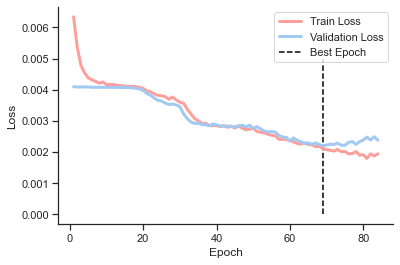

In [8]:
# Plots of training epochs
epoch = np.arange(1, len(train_loss) + 1)
plt.figure()
plt.plot(epoch, train_loss, "r", epoch, val_loss, "b", linewidth=3)
plt.vlines(stopper.best_epoch, ymin=0, ymax=0.005, colors="black", linestyles='dashed')
plt.legend(["Train Loss", "Validation Loss", "Best Epoch"])
plt.xlabel("Epoch"), plt.ylabel("Loss")

## Evaluate using the best model

Best model is stored as early_stopping_state.pt and loaded into a new object

In [9]:
final_model = Net(n_local_feat, n_global_feat)
final_model.load_state_dict(torch.load(model_path + model_name))
train_runner.model = final_model
val_runner.model = final_model
test_runner.model = final_model

In [10]:
train_runner.reset()
val_runner.reset()
test_runner.reset()

train_runner.evaluation_mode() # Set to validation to avoid more training
train_runner.run_epoch()
val_runner.run_epoch()
test_runner.run_epoch()

Evaluation on Training Data:
Loss: 0.0017659547796660064
MCC: 0.7455850947761212
Confussion Matrix:
 [[2895  240]
 [ 169  876]] 

Evaluation on Validation Data:
Loss: 0.0022076505820998044
MCC: 0.627257302463863
Confussion Matrix:
 [[1013  133]
 [  89  291]] 

Evaluation on Test Data:
Loss: 0.002706842967667852
MCC: 0.5360964443395385
Confussion Matrix:
 [[790 116]
 [ 98 203]] 



Text(0.5, 1.0, 'Test Data')

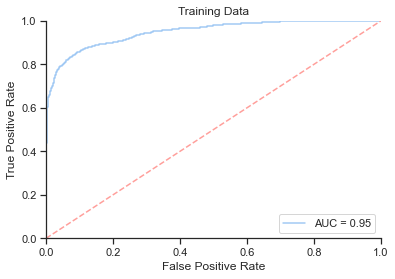

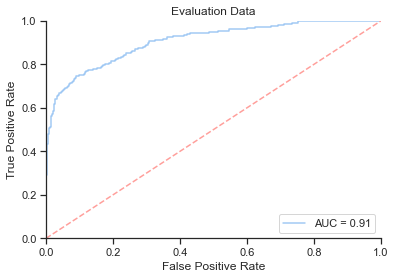

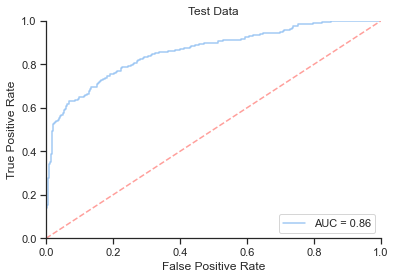

In [14]:
print("Evaluation on Training Data:")
train_runner.evaluate_model()
plt.title("Training Data")

print("Evaluation on Validation Data:")
val_runner.evaluate_model()
plt.title("Evaluation Data")

print("Evaluation on Test Data:")
test_runner.evaluate_model()
plt.title("Test Data")

